# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Operaciones de aprendizaje automático (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Gerardo Rodríguez Hernández
#### 👩‍🏫 **Profesor titular :** Maestro Ricardo Valdez Hernández
#### 👩‍🏫 **Profesor tutor :** Jorge Gonzales Zapata

### 📊 **Fase 1 Proyecto MLOps**

#### 📅 **12 de Octubre de 2025**

### 👥 Equipo 43

* 🧑‍💻 **A01795645 :** Alberto Campos Hernández
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795922 :** Jessica Giovana García Gómez
* 🧑‍💻 **A01795897 :** Esteban Sebastián Guerra Espinoza
* 🧑‍💻 **A00820345 :** Rafael Sánchez Marmolejo


## SOLO PARA GOOGLE COLAB

**IMPORTANTE:** Esta celda solo debe ejecutarse si corres el notebook en Google Colab. Si trabajas localmente, **elimina o salta esta celda**.

In [ ]:
# SOLO EJECUTAR EN GOOGLE COLAB
# Si trabajas localmente, comenta o elimina esta celda

from google.colab import files
import os

# Crear directorios necesarios
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

print("Por favor, sube los siguientes archivos CSV:")
print("1. power_tetouan_city_original.csv")
print("2. power_tetouan_city_modified.csv")
print()

uploaded = files.upload()

# Mover archivos a la carpeta correcta
for filename in uploaded.keys():
    if filename.contains("modified"):
        destination = f'../data/processed/{filename}'
    else:
        destination = f'../data/raw/{filename}'
    os.rename(filename, destination)
    print(f'✓ {filename} guardado en {destination}')

print()
print("Archivos listos. Continúa ejecutando las siguientes celdas.")

# 1. Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Configuración global de paralelismo para todos los modelos
N_JOBS = 2

In [3]:
ruta_guardado = "../data/processed/power_tetouan_city_processed.csv"

# 2. Leyendo los archivos

In [4]:
# Se lee el archivo original provisto, con el fin de comparar ambos datasets, después de realizar el EDA.
df_original = pd.read_csv("../data/raw/power_tetouan_city_original.csv",
                          na_values=['nan','NAN','NaT',''],
                        keep_default_na=True
)

# Se lee el archivo modificado "original", con el cual se realizará el ejercicio de EDA.
df = pd.read_csv(ruta_guardado,
                          na_values=['nan','NAN','NaT',''],
                        keep_default_na=True
)

In [5]:
df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Day,Month,Hour,Minute,Day of Week,Quarter of Year,Day of Year
0,6.559,73.8,0.083,0.051,5.567,34055.69620,16128.87538,20240.96386,1,1,0,0,7,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,1,1,0,10,7,1,1
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,1,1,0,20,7,1,1
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,1,1,0,30,7,1,1
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,1,1,0,40,7,1,1


# Preparación de Model

In [6]:
df.columns=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']

In [7]:
df = df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']]
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Day,Month,Hour,Minute,DayWeek,QuarterYear,DayYear
0,6.559,73.8,0.083,0.051,5.567,34055.69620,16128.87538,20240.96386,1,1,0,0,7,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,1,1,0,10,7,1,1
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,1,1,0,20,7,1,1
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,1,1,0,30,7,1,1
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,1,1,0,40,7,1,1


## Análisis de correlación

<Axes: >

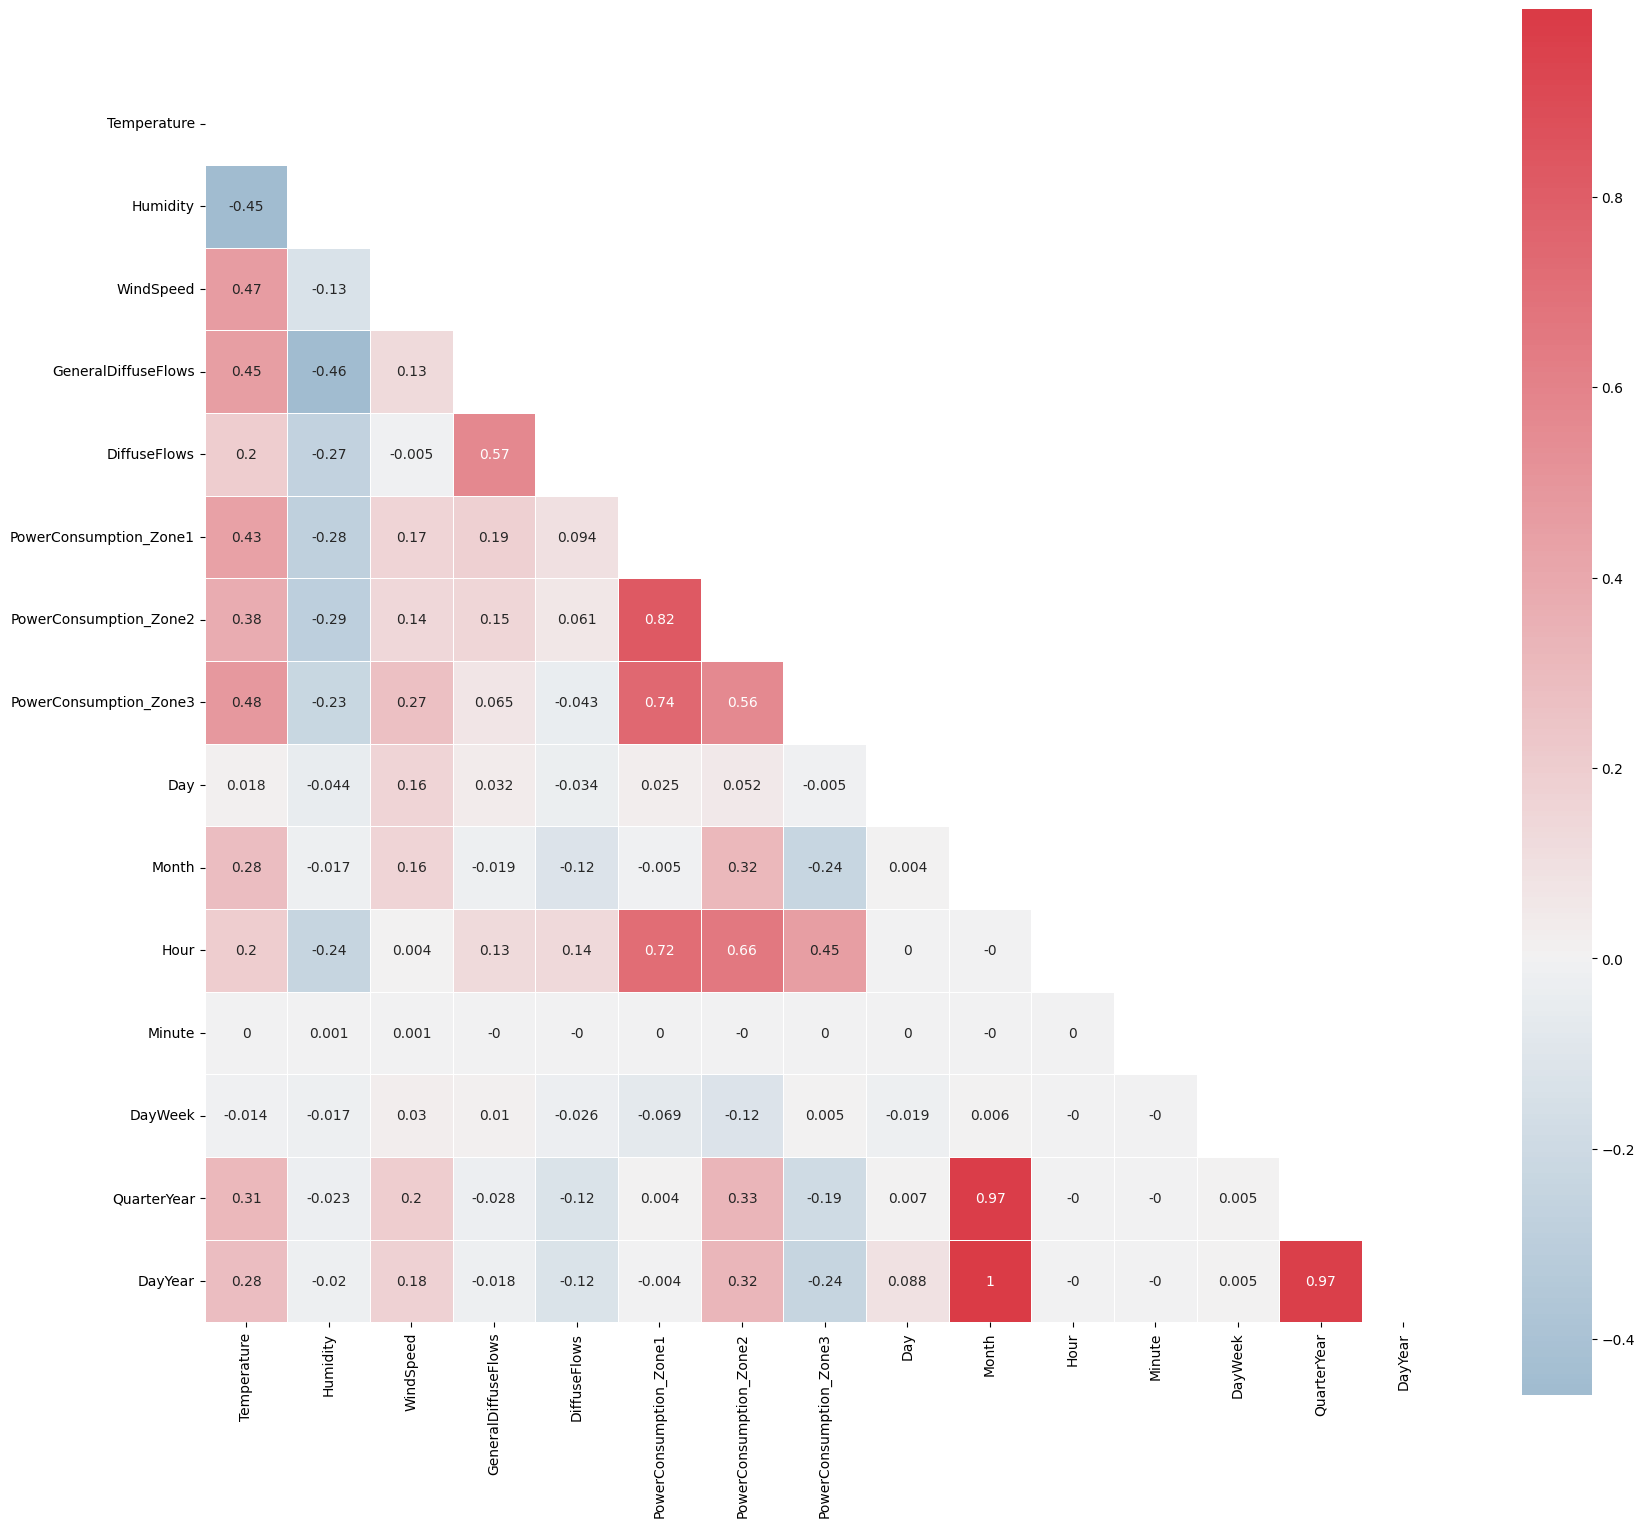

In [8]:
corr = df.corr().round(decimals=3)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

## Separación de variables y datasets de entrenamiento y pruebas

In [9]:
X=df.drop(columns=['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'])
Y=df[['PowerConsumption_Zone2']]

In [10]:
#n = len(df)
#i = int(n * 0.80)

#x_train, y_train = X.iloc[:i], Y.iloc[:i]
#x_test,  y_test  = X.iloc[i:],  Y.iloc[i:]

x_train, x_test, y_train, y_test = train_test_split(
    X, 
    Y, 
    test_size=0.2,
    random_state=42
)

## Aplicación de Modelos

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])
num_pipeline_nombres = ['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows']


#('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore')

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres)],
                                        remainder='passthrough')

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except (ImportError, Exception) as e:
    XGBOOST_AVAILABLE = False
    print(f"XGBoost no está disponible: {type(e).__name__}")
    print("   Los demás modelos funcionarán correctamente.")

def mis_modelos():
    """
    Define múltiples modelos de Machine Learning para comparación.

    Returns:
        modelos (list): Lista de modelos instanciados
        nombres (list): Lista de nombres de modelos
    """
    modelos, nombres = list(), list()

    # 1. Random Forest Regressor
    modelos.append(RandomForestRegressor(
        n_estimators=700,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=3,
        random_state=42,
        n_jobs=N_JOBS
    ))
    nombres.append('RandomForest')

    # 2. ElasticNet (Regularización L1 + L2)
    modelos.append(ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        random_state=42,
        max_iter=5000
    ))
    nombres.append('ElasticNet')

    # 3. Gradient Boosting Regressor
    modelos.append(GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42
    ))
    nombres.append('GradientBoosting')

    # 4. XGBoost (si está disponible)
    if XGBOOST_AVAILABLE:
        modelos.append(XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            random_state=42,
            n_jobs=N_JOBS
        ))
        nombres.append('XGBoost')

    # 5. Support Vector Regressor
    modelos.append(SVR(
        kernel='rbf',
        C=100,
        epsilon=0.1,
        gamma='scale'
    ))
    nombres.append('SVR')

    return modelos, nombres

K fold aleatorio (no se recomienda mucho porque tiene aleatoriedad y pierde la temporalidad)

>> RandomForest RMSE 917.969 (29.550)
>> ElasticNet RMSE 3350.904 (16.632)
>> GradientBoosting RMSE 1009.957 (25.108)
>> XGBoost RMSE 1003.213 (27.878)
>> SVR RMSE 3751.955 (28.506)


/var/folders/vr/x3cn7k1n7v12_vr58fwzpfkr0000gn/T/ipykernel_74547/3754483999.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados, labels=nombres, showmeans=True)


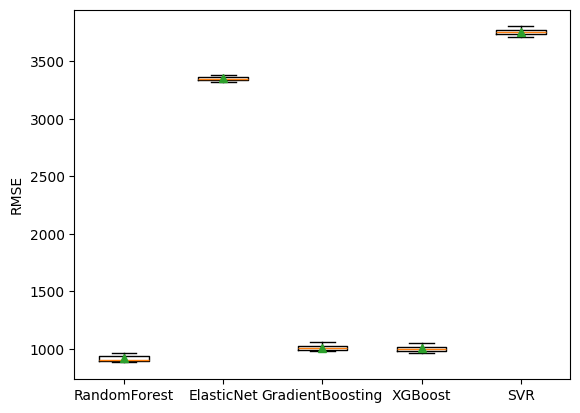

In [13]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

modelos, nombres = mis_modelos()
resultados = []

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=8)

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos[i])])

    # MSE negativo -> convierto a RMSE
    mse_scores = cross_val_score(pipeline, x_train, np.ravel(y_train),
                                 scoring='neg_mean_squared_error',
                                 cv=cv, n_jobs=N_JOBS)
    rmse_scores = np.sqrt(-mse_scores)

    resultados.append(rmse_scores)
    print(f">> {nombres[i]} RMSE {rmse_scores.mean():.3f} ({rmse_scores.std():.3f})")

plt.boxplot(resultados, labels=nombres, showmeans=True)
plt.ylabel("RMSE")
plt.show()

Entreno normal

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rf1 = RandomForestRegressor(n_estimators=700, min_samples_split=2, min_samples_leaf=1,max_features=3)

Xx = columnasTransformer.fit_transform(x_train)
mejor_result = rf1.fit(Xx, np.ravel(y_train))

X_test_t = columnasTransformer.transform(x_test)
y_true = np.ravel(y_test)
y_pred = mejor_result.predict(X_test_t)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # %

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.3f}%")

MSE:  762023.905863
RMSE: 872.939807
MAPE: 2.522%


# 5. Comparación Completa de Modelos

En esta sección entrenaremos y evaluaremos múltiples algoritmos de Machine Learning para seleccionar el mejor modelo para predecir el consumo de energía en la Zona 2.

## 5.1 Evaluación con Cross-Validation

In [15]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import time

modelos, nombres = mis_modelos()
resultados_cv = []
tiempos_entrenamiento = []

n_splits = 5
n_repeats = 3

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=8)

print("="*70)
print("EVALUACIÓN DE MODELOS CON CROSS-VALIDATION")
print("="*70)
print(f"Estrategia: {n_splits} folds, {n_repeats} repeticiones")
print(f"Total de iteraciones por modelo: {n_splits * n_repeats}")
print("="*70)
print()

for i in range(len(modelos)):
    print(f"Entrenando {nombres[i]}...")
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos[i])])

    # Medir tiempo de entrenamiento
    inicio = time.time()

    # MSE negativo -> convierto a RMSE
    mse_scores = cross_val_score(pipeline, x_train, np.ravel(y_train),
                                 scoring='neg_mean_squared_error',
                                 cv=cv, n_jobs=N_JOBS)
    rmse_scores = np.sqrt(-mse_scores)

    tiempo_transcurrido = time.time() - inicio
    tiempos_entrenamiento.append(tiempo_transcurrido)

    resultados_cv.append(rmse_scores)

    print(f"  ✓ {nombres[i]:20s} | RMSE: {rmse_scores.mean():,.2f} (±{rmse_scores.std():,.2f}) | Tiempo: {tiempo_transcurrido:.2f}s")
    print()

print("="*70)
print("Evaluación completada.")
print("="*70)

EVALUACIÓN DE MODELOS CON CROSS-VALIDATION
Estrategia: 5 folds, 3 repeticiones
Total de iteraciones por modelo: 15

Entrenando RandomForest...
  ✓ RandomForest         | RMSE: 917.89 (±30.61) | Tiempo: 113.83s

Entrenando ElasticNet...
  ✓ ElasticNet           | RMSE: 3,350.98 (±22.83) | Tiempo: 2.01s

Entrenando GradientBoosting...
  ✓ GradientBoosting     | RMSE: 1,008.47 (±26.07) | Tiempo: 232.16s

Entrenando XGBoost...
  ✓ XGBoost              | RMSE: 1,002.95 (±28.07) | Tiempo: 2.88s

Entrenando SVR...
  ✓ SVR                  | RMSE: 3,752.04 (±26.12) | Tiempo: 178.09s

Evaluación completada.


/var/folders/vr/x3cn7k1n7v12_vr58fwzpfkr0000gn/T/ipykernel_74547/672350147.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(resultados_cv, labels=nombres, showmeans=True)


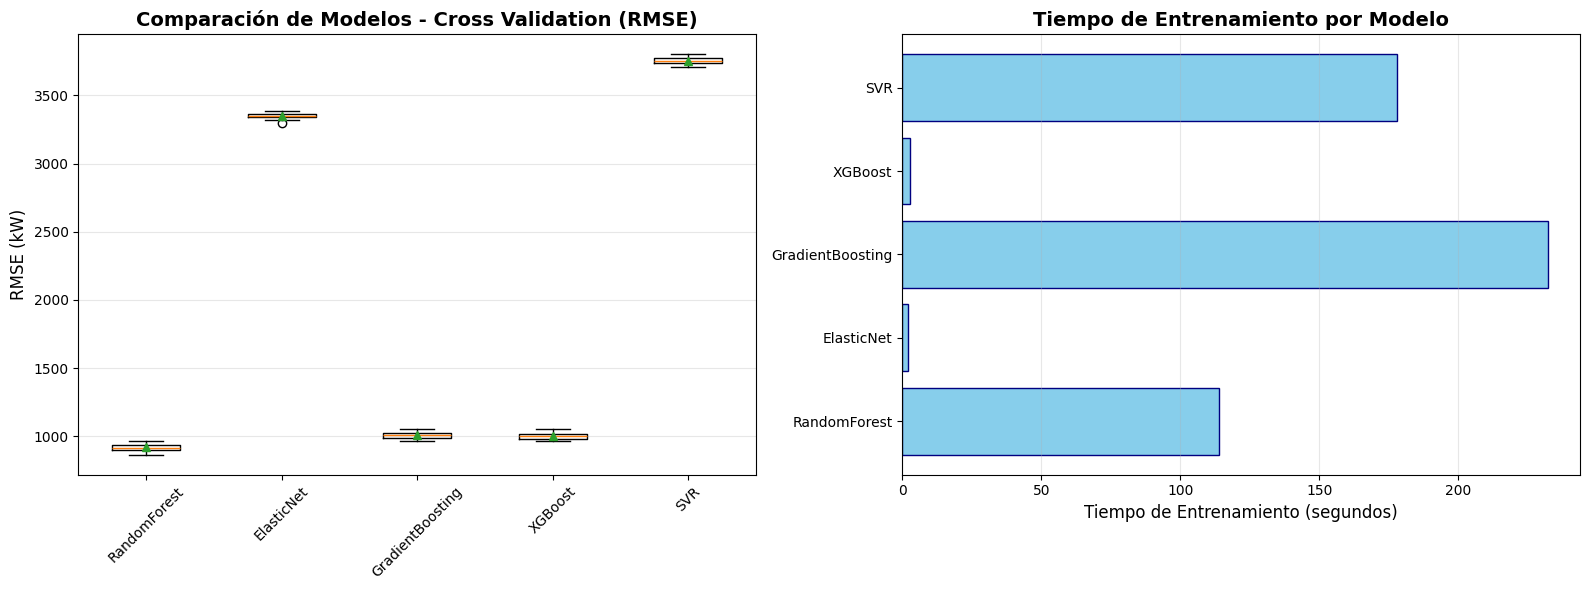

In [16]:
# Visualización de resultados Cross-Validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot de RMSE
axes[0].boxplot(resultados_cv, labels=nombres, showmeans=True)
axes[0].set_ylabel("RMSE (kW)", fontsize=12)
axes[0].set_title("Comparación de Modelos - Cross Validation (RMSE)", fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de barras de tiempo de entrenamiento
axes[1].barh(nombres, tiempos_entrenamiento, color='skyblue', edgecolor='navy')
axes[1].set_xlabel("Tiempo de Entrenamiento (segundos)", fontsize=12)
axes[1].set_title("Tiempo de Entrenamiento por Modelo", fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5.2 Evaluación en Test Set

Ahora entrenaremos todos los modelos con el conjunto completo de entrenamiento y evaluaremos su desempeño en el conjunto de prueba.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Preparar datos transformados
X_train_transformed = columnasTransformer.fit_transform(x_train)
X_test_transformed = columnasTransformer.transform(x_test)
y_train_flat = np.ravel(y_train)
y_test_flat = np.ravel(y_test)

# Almacenar resultados
resultados_test = []
modelos_entrenados = []

print("="*90)
print("EVALUACIÓN EN TEST SET")
print("="*90)
print(f"{'Modelo':<20} {'RMSE':>12} {'MAE':>12} {'MAPE':>10} {'R²':>8} {'Tiempo':>10}")
print("="*90)

for i in range(len(modelos)):
    # Entrenar modelo
    inicio = time.time()
    modelo = modelos[i]
    modelo.fit(X_train_transformed, y_train_flat)
    tiempo_fit = time.time() - inicio

    # Predecir
    y_pred = modelo.predict(X_test_transformed)

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred))
    mae = mean_absolute_error(y_test_flat, y_pred)
    mape = mean_absolute_percentage_error(y_test_flat, y_pred) * 100
    r2 = r2_score(y_test_flat, y_pred)

    resultados_test.append({
        'modelo': nombres[i],
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'tiempo': tiempo_fit
    })

    modelos_entrenados.append(modelo)

    print(f"{nombres[i]:<20} {rmse:>12,.2f} {mae:>12,.2f} {mape:>9,.2f}% {r2:>8,.4f} {tiempo_fit:>9,.2f}s")

print("="*90)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados_test)
df_resultados = df_resultados.sort_values('rmse')
print("\n Ranking de Modelos (ordenado por RMSE):")
print(df_resultados.to_string(index=False))

EVALUACIÓN EN TEST SET
Modelo                       RMSE          MAE       MAPE       R²     Tiempo
RandomForest               874.06       505.04      2.53%   0.9714     15.70s
ElasticNet               3,355.92     2,660.25     13.24%   0.5788      0.14s
GradientBoosting           992.00       635.44      3.17%   0.9632     36.16s
XGBoost                    978.80       615.50      3.06%   0.9642      0.35s
SVR                      3,647.56     2,948.22     14.78%   0.5024     23.42s

 Ranking de Modelos (ordenado por RMSE):
          modelo        rmse         mae      mape       r2    tiempo
    RandomForest  874.061356  505.040071  2.525656 0.971424 15.701988
         XGBoost  978.804533  615.499100  3.062269 0.964165  0.348981
GradientBoosting  991.998980  635.442752  3.168903 0.963193 36.163825
      ElasticNet 3355.923099 2660.254120 13.237044 0.578755  0.144776
             SVR 3647.560878 2948.218232 14.783443 0.502359 23.418082


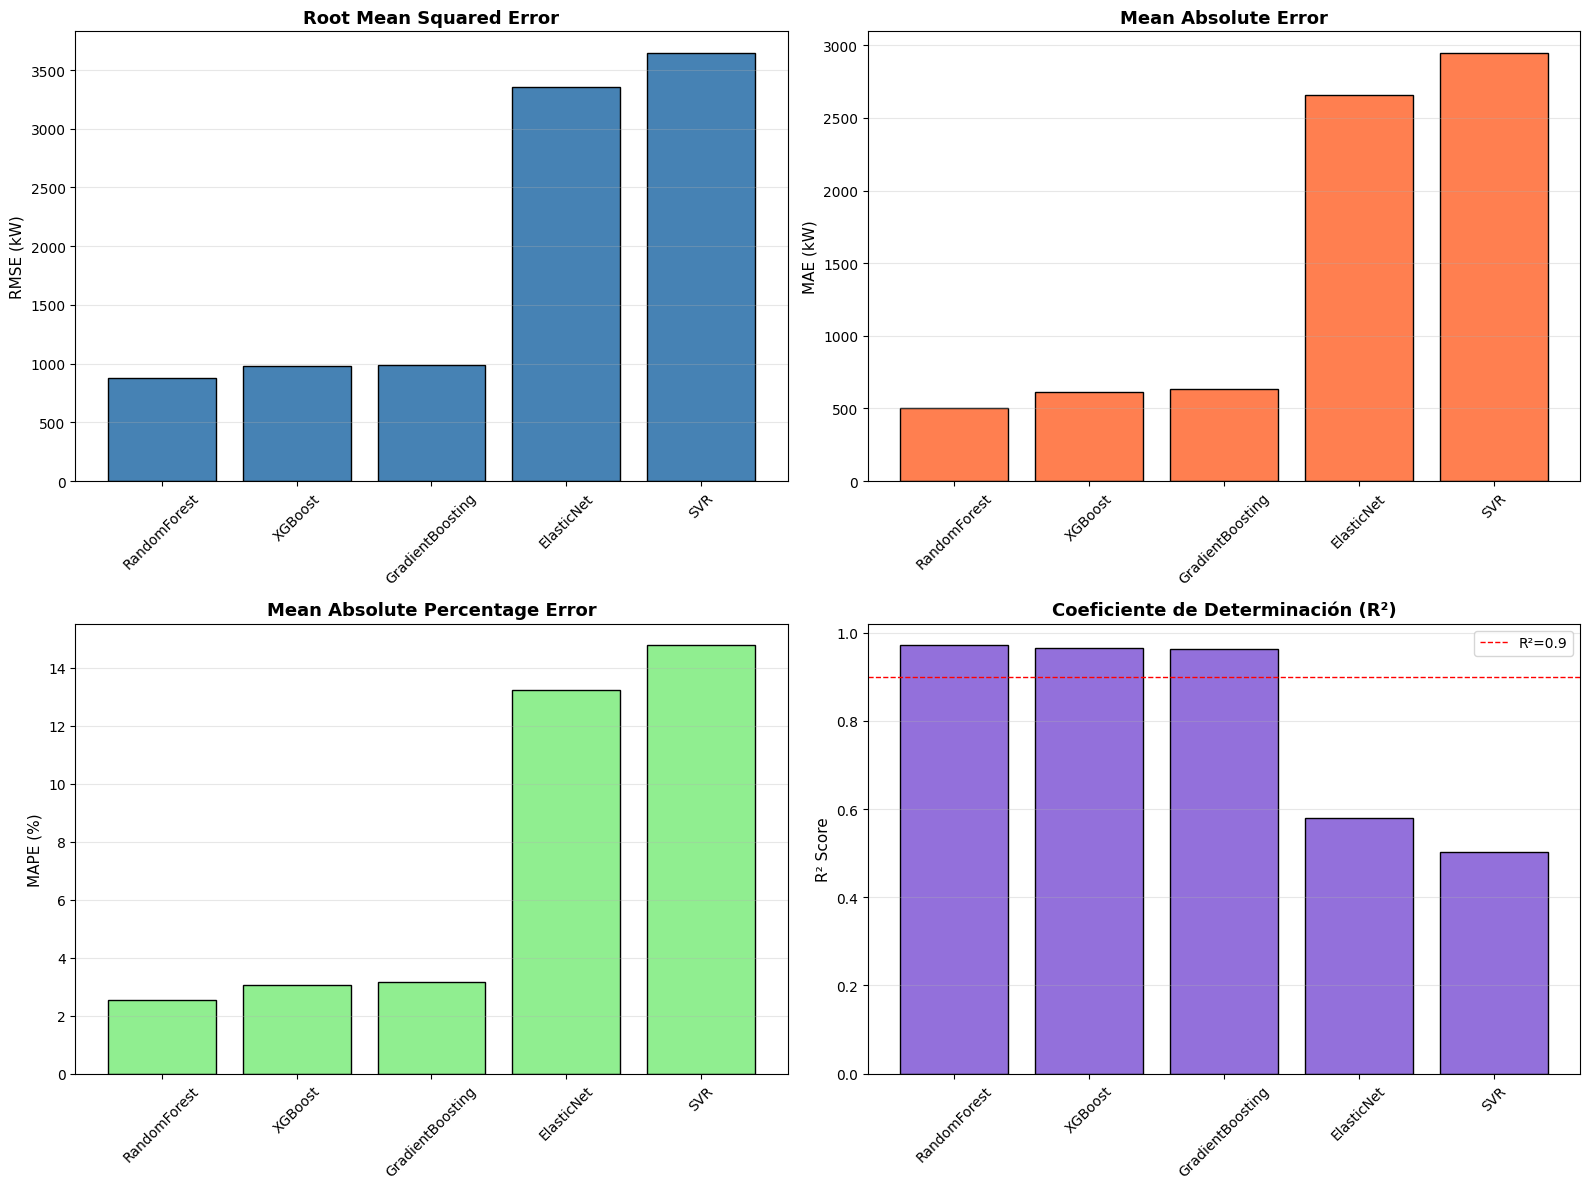

In [18]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0, 0].bar(df_resultados['modelo'], df_resultados['rmse'], color='steelblue', edgecolor='black')
axes[0, 0].set_ylabel('RMSE (kW)', fontsize=11)
axes[0, 0].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE
axes[0, 1].bar(df_resultados['modelo'], df_resultados['mae'], color='coral', edgecolor='black')
axes[0, 1].set_ylabel('MAE (kW)', fontsize=11)
axes[0, 1].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAPE
axes[1, 0].bar(df_resultados['modelo'], df_resultados['mape'], color='lightgreen', edgecolor='black')
axes[1, 0].set_ylabel('MAPE (%)', fontsize=11)
axes[1, 0].set_title('Mean Absolute Percentage Error', fontsize=13, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# R²
axes[1, 1].bar(df_resultados['modelo'], df_resultados['r2'], color='mediumpurple', edgecolor='black')
axes[1, 1].set_ylabel('R² Score', fontsize=11)
axes[1, 1].set_title('Coeficiente de Determinación (R²)', fontsize=13, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0.9, color='red', linestyle='--', linewidth=1, label='R²=0.9')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5.3 Análisis del Mejor Modelo

Identificaremos el mejor modelo basándose en las métricas de evaluación y generaremos predicciones detalladas.

MEJOR MODELO: RandomForest
RMSE:  874.06 kW
MAE:   505.04 kW
MAPE:  2.526%
R²:    0.971424


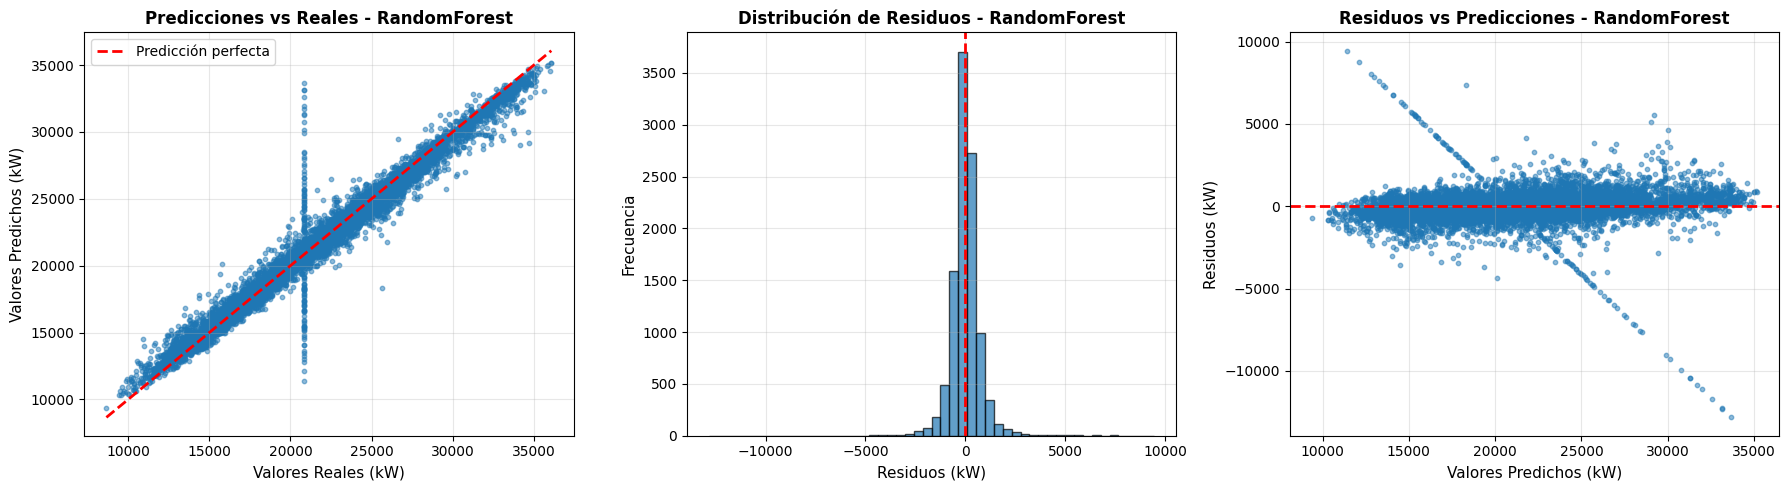


Estadísticas de Residuos:
Media:      -4.44 kW
Desv. Std:  874.05 kW
Min:        -12,827.90 kW
Max:        9,446.84 kW


In [19]:
# Identificar mejor modelo
mejor_idx = df_resultados['rmse'].idxmin()
mejor_modelo_nombre = df_resultados.loc[mejor_idx, 'modelo']
mejor_modelo_obj = modelos_entrenados[nombres.index(mejor_modelo_nombre)]

print("="*70)
print(f"MEJOR MODELO: {mejor_modelo_nombre}")
print("="*70)
print(f"RMSE:  {df_resultados.loc[mejor_idx, 'rmse']:,.2f} kW")
print(f"MAE:   {df_resultados.loc[mejor_idx, 'mae']:,.2f} kW")
print(f"MAPE:  {df_resultados.loc[mejor_idx, 'mape']:.3f}%")
print(f"R²:    {df_resultados.loc[mejor_idx, 'r2']:.6f}")
print("="*70)

# Generar predicciones con el mejor modelo
y_pred_mejor = mejor_modelo_obj.predict(X_test_transformed)

# Análisis de residuos
residuos = y_test_flat - y_pred_mejor

# Visualización del mejor modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Predicciones vs Reales
axes[0].scatter(y_test_flat, y_pred_mejor, alpha=0.5, s=10)
axes[0].plot([y_test_flat.min(), y_test_flat.max()],
             [y_test_flat.min(), y_test_flat.max()],
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Valores Reales (kW)', fontsize=11)
axes[0].set_ylabel('Valores Predichos (kW)', fontsize=11)
axes[0].set_title(f'Predicciones vs Reales - {mejor_modelo_nombre}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Distribución de Residuos
axes[1].hist(residuos, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (kW)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title(f'Distribución de Residuos - {mejor_modelo_nombre}', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# 3. Residuos vs Predicciones
axes[2].scatter(y_pred_mejor, residuos, alpha=0.5, s=10)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Valores Predichos (kW)', fontsize=11)
axes[2].set_ylabel('Residuos (kW)', fontsize=11)
axes[2].set_title(f'Residuos vs Predicciones - {mejor_modelo_nombre}', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print("\nEstadísticas de Residuos:")
print(f"Media:      {residuos.mean():,.2f} kW")
print(f"Desv. Std:  {residuos.std():,.2f} kW")
print(f"Min:        {residuos.min():,.2f} kW")
print(f"Max:        {residuos.max():,.2f} kW")

# 6. Guía de Reproducibilidad

Esta sección contiene instrucciones detalladas para reproducir completamente este análisis y los resultados obtenidos.

## 6.1 Requisitos del Sistema

### Software Requerido
- **Python**: 3.8 o superior
- **Jupyter Notebook**: 6.0 o superior (o JupyterLab)
- **Git**: Para control de versiones
- **DVC** (opcional): Para versionamiento de datos

### Especificaciones Recomendadas de Hardware
- **RAM**: Mínimo 8GB, recomendado 16GB
- **Procesador**: Multi-core (4+ cores recomendado)
- **Espacio en disco**: Mínimo 500MB libres

## 6.2 Instalación de Dependencias

### Opción 1: Usando pip (recomendado)
```bash
# Crear entorno virtual
python -m venv venv

# Activar entorno virtual
# En Windows:
venv\Scripts\activate
# En macOS/Linux:
source venv/bin/activate

# Instalar dependencias
pip install pandas numpy matplotlib seaborn scipy scikit-learn xgboost jupyter
o pip install -r requirements.txt
```

### Opción 2: Usando conda
```bash
# Crear entorno conda
conda create -n mlops python=3.10

# Activar entorno
conda activate mlops

# Instalar dependencias
conda install pandas numpy matplotlib seaborn scipy scikit-learn jupyter
pip install xgboost
```

### Versiones de Paquetes Utilizadas
```
pandas>=1.5.0
numpy>=1.23.0
matplotlib>=3.6.0
seaborn>=0.12.0
scipy>=1.9.0
scikit-learn>=1.2.0
xgboost>=1.7.0
jupyter>=1.0.0
```

## 6.3 Estructura del Proyecto

```
MNA_MLOps/
│
├── data/
│   ├── raw/                                    # Datos originales (no modificar)
│   │   ├── power_tetouan_city_original.csv
│   │   └── power_tetouan_city_modified.csv
│   └── processed/                              # Datos procesados
│       └── power_tetouan_city_processed.csv
│
├── notebooks/
│   └── Fase 1_Equipo43.ipynb                  # Este notebook
│
├── docs/
│   └── ML_Canvas.md                           # Machine Learning Canvas
│
├── .gitignore
└── README.md
```

## 6.4 Pasos para Reproducir el Análisis

### Paso 1: Clonar o descargar el proyecto
```bash
git clone https://github.com/oscargarciatec/MNA_MLOps
cd MNA_MLOps
```

### Paso 2: Preparar los datos
1. Descargar el dataset original desde: https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city
2. Colocar los archivos CSV en `data/raw/`
3. Asegurarse de que los nombres de archivo coincidan:
   - `power_tetouan_city_original.csv`
   - `power_tetouan_city_modified.csv`

### Paso 3: Ejecutar el Notebook
1. Abrir Jupyter Notebook:
   ```bash
   jupyter notebook
   ```
2. Navegar a `notebooks/Fase 1_Equipo43_EDA.ipynb`
3. Ejecutar todas las celdas en orden: **Cell → Run All**

NOTA IMPORTANTE: Es importante mencionar que el último archivo en el repositorio ya cuenta con la aplicación de todo el EDA (Primer notebook), por lo que NO es necesario ejecutar este notebook si se recupera el dataset con el versionamiento DVC (Revisar sección 7.4)

4. Navegar a `notebooks/Fase 1_Equipo43_models.ipynb`
5. Ejecutar todas las celdas en orden: **Cell → Run All**

### Paso 4: Verificar Resultados
- El archivo procesado se guardará automáticamente en `data/processed/`
- Los gráficos se mostrarán inline en el notebook
- Las métricas de evaluación se imprimirán en la salida

## 6.5 Configuración de Reproducibilidad

### Seeds Aleatorias
Para garantizar resultados reproducibles, hemos fijado las siguientes semillas:

```python
# En el código de modelos
random_state=42  # Para todos los modelos de sklearn
np.random.seed(42)  # Para operaciones de numpy
```

### Orden de Ejecución
**IMPORTANTE**: Las celdas deben ejecutarse en orden secuencial. Algunas celdas dependen de variables creadas en celdas anteriores.

### Tiempos de Ejecución Esperados
- **EDA y Preprocesamiento**: ~2-3 minutos
- **Cross-Validation (todos los modelos)**: ~10-15 minutos
- **Entrenamiento final y evaluación**: ~2-3 minutos
- **Total**: ~15-20 minutos (puede variar según hardware)

## 6.6 Solución de Problemas Comunes

### Problema: XGBoost no se instala
**Solución:**
```bash
pip install xgboost
# Si falla, intenta:
conda install -c conda-forge xgboost
```

### Problema: Errores de memoria (MemoryError)
**Soluciones:**
1. Reducir n_estimators en Random Forest y XGBoost
2. Reducir cv.n_repeats en cross-validation
3. Usar un subset de datos para pruebas iniciales

### Problema: FileNotFoundError
**Solución:**
- Verificar que los archivos CSV estén en `data/raw/`
- Verificar que los nombres de archivo sean exactos
- Verificar que estás ejecutando desde el directorio raíz del proyecto

### Problema: Diferentes resultados en diferentes ejecuciones
**Causa**: Las semillas aleatorias no están fijadas correctamente
**Solución**: Verificar que todos los modelos tengan `random_state=42`

## 6.7 Contacto y Soporte

Para preguntas o problemas con la reproducción:
- **Equipo 43**: Ver autores en la sección inicial del notebook
- **Issues**: Crear un issue en el repositorio del proyecto
- **Email**: A01795645@tec.mx

## 6.8 Licencia y Citación

### Dataset
- **Fuente**: UCI Machine Learning Repository
- **Licencia**: CC BY 4.0
- **Citación**: Salam, A., & El Hibaoui, A. (2023). Power Consumption of Tetouan City Dataset. UCI Machine Learning Repository.

### Código
- Proyecto académico - Tecnológico de Monterrey
- Curso: Operaciones de Aprendizaje Automático (MLOps)
- Equipo 43 - Octubre 2025

# 7. Versionamiento de Datos

## 7.1 Estrategia de Versionamiento

Para este proyecto utilizamos un enfoque de versionamiento dual:

1. **Git** - Para código, notebooks y documentación
2. **DVC (Data Version Control)** - Para datasets grandes y modelos entrenados

## 7.2 Archivos Versionados

### Con Git
- ✅ Notebooks (`.ipynb`)
- ✅ Scripts Python (`.py`)
- ✅ Documentación (`.md`)
- ✅ Archivos de configuración

### Con DVC
- ✅ Datasets crudos (`data/raw/*.csv`)
- ✅ Datasets procesados (`data/processed/*.csv`)
- ✅ Modelos entrenados (`.pkl`, `.joblib`)

## 7.3 Dataset Procesado Generado

En este notebook se generó el siguiente archivo procesado:

```python
# Ubicación del archivo
ruta_guardado = "../data/processed/power_tetouan_city_processed.csv"
```

**Características del dataset procesado:**
- **Registros**: 52,418 (después de limpieza)
- **Features**: 15 (8 originales + 7 temporales derivadas)
- **Transformaciones aplicadas**:
  - Eliminación de valores duplicados
  - Tratamiento de outliers (IQR method)
  - Imputación de valores faltantes (mediana)
  - Feature engineering temporal
  - Normalización MinMaxScaler (rango 1-2)

## 7.4 Comandos de Versionamiento

### Versionar dataset con DVC (después de ejecutar este notebook)

```bash
# 1. Agregar dataset procesado a DVC
dvc add data/processed/power_tetouan_city_processed.csv

# 2. Commit el archivo .dvc a Git
git add data/processed/power_tetouan_city_processed.csv.dvc
git commit -m "[data] Add processed dataset v1.0 - IQR outlier treatment + temporal features"

# 3. Push datos a DVC remote storage
dvc push

# 4. Push commits a GitHub
git push origin main
```

### Recuperar dataset (para nuevos miembros del equipo)

```bash
# Después de clonar el repositorio
git clone https://github.com/oscargarciatec/MNA_MLOps
cd MNA_MLOps

# Descargar datos versionados
dvc pull
```

NOTA IMPORTANTE: Es importante mencionar que el último archivo en el repositorio ya cuenta con la aplicación de todo el EDA (Primer notebook), por lo que NO es necesario ejecutar este notebook si se recupera el dataset con los comandos anteriores.

## 7.5 Documentación Completa

Para información detallada sobre el proceso de versionamiento, consultar:

📄 **`docs/Data_Versioning.md`**

Este documento incluye:
- Configuración paso a paso de DVC
- Mejores prácticas de versionamiento
- Workflow completo
- Troubleshooting común
- Convenciones de nomenclatura

## 7.6 Historial de Versiones del Dataset

| Versión | Fecha | Descripción | Registros | Features |
|---------|-------|-------------|-----------|----------|
| v1.0 | 2025-10-09 | Dataset inicial procesado | 52,418 | 15 |

### Cambios v1.0
- ✅ Eliminación de columna `mixed_type_col`
- ✅ Imputación de valores faltantes (mediana)
- ✅ Eliminación de 1,045 timestamps duplicados
- ✅ Tratamiento de outliers con IQR + mediana local
- ✅ Creación de 7 features temporales (Day, Month, Hour, etc.)
- ✅ Normalización con MinMaxScaler (1-2)

---

**Nota**: Este dataset procesado es el utilizado para entrenar y evaluar todos los modelos en la Sección 5.